In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

import time

from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Project
!pwd

import utils

/content/drive/My Drive/Project
/content/drive/My Drive/Project


['.DS_Store', 'validation', 'train']
Train Classes - ['.DS_Store', 'surprised', 'scared', 'sad', 'neutral', 'happy', 'disgusted', 'angry']
Validation Classes - ['.DS_Store', 'surprised', 'scared', 'sad', 'neutral', 'happy', 'disgusted', 'angry']
Feature batch shape: torch.Size([200, 1, 128, 128])
Labels batch shape: torch.Size([200])


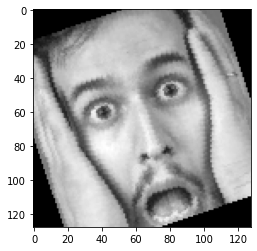

Label: 5
torch.Size([1, 128, 128])


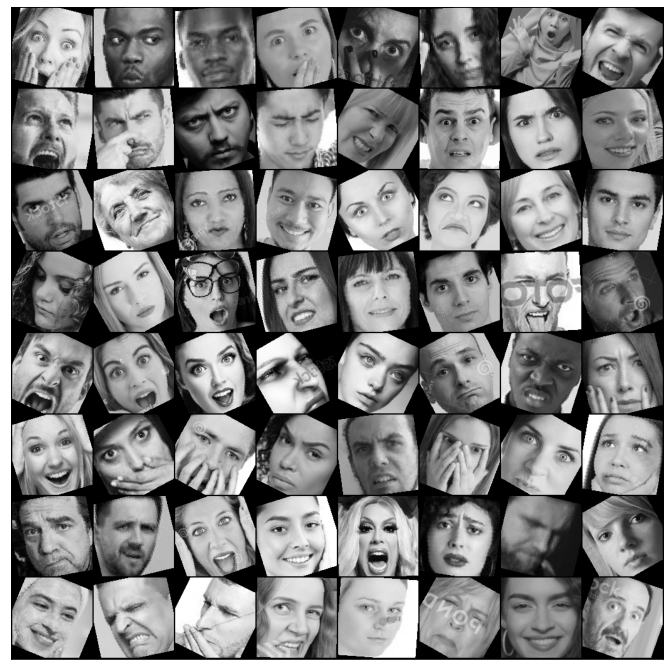

In [3]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         # tt.Resize((28,28)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         # tt.Resize((28,28)), 
                         tt.ToTensor()])

# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

batch_size = 200

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [ ]:
num_of_pixels = len(train_ds) * 128 * 128
total_sum = 0
for batch in train_dl:
    total_sum += batch[0].sum()
mean = total_sum / num_of_pixels

sum_of_squared_error = 0
for batch in train_dl: 
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

## LeNet5
Over here, we train a simple LeNet5 Architecture that was proposed by LeCun and team in 1998. It has a total of two sets of convolution layers with a combination of subsampling, followed by two fully connected layers.

 

1.   The first layer is the input layer with feature map size 1x128x128.
2.   Then, we have the convolution layer with 50 filters of size 3x3 and stride 1. The activation function used at this layer is ReLU. The output feature map is 50x128x128.
3.   Next, we have an average pooling layer with filter size 2x2 and stride 1. The resulting feature map is 50x64x64.
4.   Then, we have a second convolution layer with 100 filters of size 3x3 and stride 1. The activation function used at this layer is ReLU. The output feature map is 100x64x64.
5.   Next, we have an average pooling layer with filter size 2x2 and stride 1. The resulting feature map is 100x32x32.
6.   Then, we have a fully connected layer with 100 neurons that results in the output of 100 values. The activation function used is also ReLU.
7.   Finally, we have a final connected layer with 7 neurons to output 7 values that will represent the class that a data point would belong to.

In [4]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 64 x 64
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 64 x 64 -->    100 x 32 x 32
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 32 x 32 = 102,400 -->  100
        self.linear1 = nn.Linear(102400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        self.x1 = self.conv1(x)
        self.x2 = torch.relu(self.x1)
        self.x3 = self.pool1(self.x2)
        self.x4 = self.conv2(self.x3)
        self.x5 = torch.relu(self.x4)
        self.x6 = self.pool2(self.x5)
        self.x7 = self.x6.view(-1, 102400)
        self.x8 = self.linear1(self.x7)
        self.x9 = torch.relu(self.x8)
        self.out = self.linear2(self.x9)
    
        return self.out

    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7, self.x8, self.x9, self.out

The number of trainable parameters of this architecture is approximately 10.29 million.

In [5]:
net = LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=102400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 10286407 (10.29 million) parameters in this neural network


Over here, we are doing 200 passes through the training set and dividing the learning rate by 1.5 every 10 epochs to decay it.

In [6]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
device = torch.device('cuda')
net = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

epoch= 1 	 time= 6.661961348851522 min 	 lr= 0.25 	 loss= 1.9702238035202027 	 error= 82.66000080108643 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 2 	 time= 7.951790396372477 min 	 lr= 0.25 	 loss= 1.932634859085083 	 error= 80.70000076293945 percent
error rate on test set = 81.16161823272705 percent
 
epoch= 3 	 time= 8.179031737645467 min 	 lr= 0.25 	 loss= 1.9336142015457154 	 error= 80.82000064849854 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 4 	 time= 8.408081058661143 min 	 lr= 0.25 	 loss= 1.9312482738494874 	 error= 80.760000705719 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 5 	 time= 8.637881529331207 min 	 lr= 0.25 	 loss= 1.9255378866195678 	 error= 79.20000052452087 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 6 	 time= 8.868585646152496 min 	 lr= 0.25 	 loss= 1.9193805265426636 	 error= 79.51999998092651 percent
error rate on test set = 79.78282968203226 percent
 
epoch= 7 	 time= 

In [9]:
torch.save(net.state_dict(), 'trained_models/emotion/lenet5_128_rotate.pt')

## LeNet5 -- nn.MaxPool2d(4 x 4)

The attempted improvement done over here is to increase the size of the average pooling layers from 2x2 to 4x4. This was done for multiple reasons.

We do not wish to resize the input layer of 1x128x128 first because this image classification tasks deals with facial expressions and facial features which are detailed and may contain useful features for each small pixel. However, due to the size of the input layer, it results in a number of parameters in the neural network. This may result in overfitting.

Hence, to reduce the number of parameters, while seeking to retain the information captured at fine-grain pixel level, we attemp to increase the size of the average pooling layers.

In [48]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 32 x 32
        self.pool1  = nn.MaxPool2d(4,4)
        
        # CL2:   50 x 32 x 32  -->    100 x 32 x 32 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 32 x 32 -->    100 x 8 x 8
        self.pool2 = nn.MaxPool2d(4,4)
        
        # LL1:   100 x 8 x 8 = 6400 -->  100
        self.linear1 = nn.Linear(6400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        self.x1 = self.conv1(x)
        self.x2 = torch.relu(self.x1)
        self.x3 = self.pool1(self.x2)
        self.x4 = self.conv2(self.x3)
        self.x5 = torch.relu(self.x4)
        self.x6 = self.pool2(self.x5)
        self.x7 = self.x6.view(-1, 6400)
        self.x8 = self.linear1(self.x7)
        self.x9 = torch.relu(self.x8)
        self.out = self.linear2(self.x9)
    
        return self.out

    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7, self.x8, self.x9, self.out

In [49]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 686407 (0.69 million) parameters in this neural network


In [50]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
device = torch.device('cuda')
net = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

epoch= 1 	 time= 0.15357844432195028 min 	 lr= 0.25 	 loss= 1.937640199661255 	 error= 81.16000056266785 percent
error rate on test set = 82.5000007947286 percent
 
epoch= 2 	 time= 0.3268059770266215 min 	 lr= 0.25 	 loss= 1.930358691215515 	 error= 81.42000007629395 percent
error rate on test set = 83.21212132771811 percent
 
epoch= 3 	 time= 0.4992769757906596 min 	 lr= 0.25 	 loss= 1.9228908109664917 	 error= 79.90000081062317 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 4 	 time= 0.6723734458287557 min 	 lr= 0.25 	 loss= 1.913659052848816 	 error= 78.62000012397766 percent
error rate on test set = 78.78787914911905 percent
 
epoch= 5 	 time= 0.8460733413696289 min 	 lr= 0.25 	 loss= 1.9360142374038696 	 error= 80.5 percent
error rate on test set = 82.16666777928671 percent
 
epoch= 6 	 time= 1.0133268713951111 min 	 lr= 0.25 	 loss= 1.9022597932815553 	 error= 78.84000039100647 percent
error rate on test set = 74.80808099110922 percent
 
epoch= 7 	 time= 1.18

In [51]:
torch.save(net.state_dict(), 'trained_models/emotion/lenet5_128_rotate_4x4.pt')

## Slow Down Decaying of LR
In the previous rounds, we notice that the LR decayed too quickly. Hence, the error rate on test set stagnant at an early stage. Hence, over here, we decrease learning rate only after 50 epoch instead of 10 epoch.

In [52]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

criterion = nn.CrossEntropyLoss()
my_lr = 0.25
device = torch.device('cuda')
net = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%50:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 686407 (0.69 million) parameters in this neural network
epoch= 1 	 time= 0.15087319612503053 min 	 lr= 0.25 	 loss= 1.934810633659363 	 error= 81.92000102996826 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 2 	 time= 0.31600950558980306 min 	 lr= 0.25 	 loss= 1.9305361032485961 	 error= 81.12000036239624 percent
error rate on test set = 79.88888820012411 percent
 
epoch= 3 	 time= 0.4836360772450765 min 	 lr= 0.25 	 loss= 1.9260465669631959 	 error= 80.28000068664551 percent
error rate on 

In [53]:
torch.save(net.state_dict(), 'trained_models/emotion/lenet5_128_rotate_4x4_reducedLR.pt')

## Reduce Dimension of Input Data

['validation', 'train']
Train Classes - ['surprised', 'scared', 'sad', 'neutral', 'happy', 'disgusted', 'angry']
Validation Classes - ['surprised', 'scared', 'sad', 'neutral', 'happy', 'disgusted', 'angry']
Feature batch shape: torch.Size([200, 1, 48, 48])
Labels batch shape: torch.Size([200])


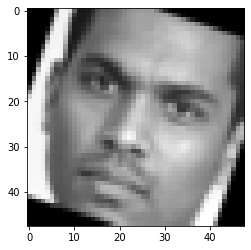

Label: 3
torch.Size([1, 48, 48])


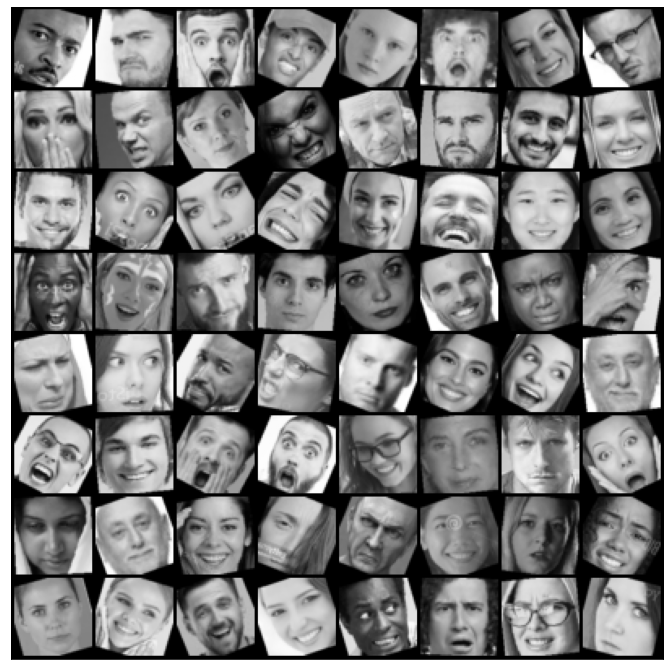

In [54]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.Resize((48,48)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), 
                         tt.Resize((48,48)),
                         tt.ToTensor()])

# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

batch_size = 200

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [55]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   48 x 48  -->    50 x 48 x 48 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 48 x 48 -->    50 x 24 x 24
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 24 x 24  -->    100 x 24 x 24 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 24 x 24 -->    100 x 12 x 12
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 12 x 12 = 14400 -->  100
        self.linear1 = nn.Linear(14400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        self.x1 = self.conv1(x)
        self.x2 = torch.relu(self.x1)
        self.x3 = self.pool1(self.x2)
        self.x4 = self.conv2(self.x3)
        self.x5 = torch.relu(self.x4)
        self.x6 = self.pool2(self.x5)
        self.x7 = self.x6.view(-1, 14400)
        self.x8 = self.linear1(self.x7)
        self.x9 = torch.relu(self.x8)
        self.out = self.linear2(self.x9)
    
        return self.out

    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7, self.x8, self.x9, self.out

In [ ]:
net=LeNet5_convnet()
print(net)
utils.display_num_param(net)

criterion = nn.CrossEntropyLoss()
my_lr = 0.25
device = torch.device('cuda')
net = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%50:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 48, 48) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = net( train_inputs ) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    valid_running_error=0
    valid_num_batches=0

    for valid_minibatch_data, valid_minibatch_label in valid_dl:

        valid_minibatch_data = valid_minibatch_data.to(device)
        valid_minibatch_label = valid_minibatch_label.to(device)
        
        valid_inputs = valid_minibatch_data.view(-1, 1, 48, 48) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

        valid_scores = net(valid_inputs) 

        valid_error = utils.get_error(valid_scores , valid_minibatch_label)

        valid_running_error += valid_error.item()

        valid_num_batches+=1


    valid_total_error = valid_running_error / valid_num_batches
    print('error rate on test set =', valid_total_error*100 , 'percent')
    print(' ')

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=14400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 1486407 (1.49 million) parameters in this neural network
epoch= 1 	 time= 0.14489864110946654 min 	 lr= 0.25 	 loss= 1.9375006723403931 	 error= 82.62000036239624 percent
error rate on test set = 87.99999952316284 percent
 
epoch= 2 	 time= 0.3067581017812093 min 	 lr= 0.25 	 loss= 1.9332253074645995 	 error= 81.2000002861023 percent
error rate on test set = 78.78787914911905 percent
 
epoch= 3 	 time= 0.4762554128964742 min 	 lr= 0.25 	 loss= 1.9271757316589355 	 error= 80.62000036239624 percent
error rate o

In [ ]:
torch.save(net.state_dict(), 'trained_models/emotion/lenet5_48_rotate_reducedLR.pt')

## Load Model Weights and Predict

In [10]:
# Load model and weights
loaded_net=LeNet5_convnet()
loaded_net.load_state_dict(torch.load('trained_models/emotion/lenet5_128_rotate.pt'))
loaded_net.eval()
loaded_net.parameters()

<generator object Module.parameters at 0x7f8e698062d0>

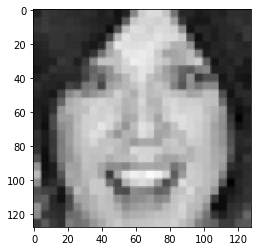

True: 4, Predicted: 1


In [29]:
# choose a picture at random
from random import randint

images, gts = list(iter(valid_dl))[randint(0, 3-1)]

idx=randint(0, images.size()[0]-1)
im = images[idx]
gt = gts[idx]

# diplay the picture
utils.show(im.squeeze(0))

# feed it to the net and display the confidence scores
scores =  loaded_net(im.view(-1, 1, 128, 128)) 
probs = torch.softmax(scores, dim=1)
print(f"True: {gt}, Predicted: {probs.argmax()}")

## Visualisation

### Visualise filter weights and feature maps in each layer

torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([50, 1, 3, 3])


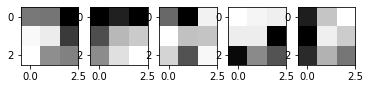

In [55]:
import matplotlib.pyplot as plt

# Visualize conv1 filter
kernels = loaded_net.conv1.weight.detach()
plt.figure()
for idx in range(kernels.size(0))[:5]:
    plt.subplot(151 + idx)
    plt.imshow(kernels[idx].squeeze(0).cpu(), cmap = 'Greys')
    # plt.imshow(kernels[idx].squeeze(), cmap = 'Greys')
    print(kernels[idx].shape, kernels[idx].squeeze().shape)
print(kernels.size())

torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([100, 50, 3, 3])


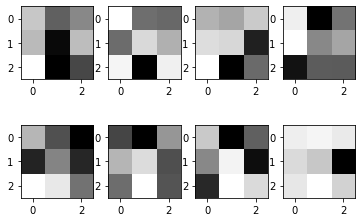

In [57]:
# Visualize conv2 filter
kernels = loaded_net.conv2.weight.detach()
plt.figure()
count = 0
for idx0 in range(kernels.size(0))[:4]:
    for idx1 in range(kernels.size(1))[:2]:
        plt.subplot(241 + count)
        count += 1
        plt.imshow(kernels[idx0][idx1].squeeze().cpu(), cmap = 'Greys')
        print(kernels[idx0][idx1].shape, kernels[idx0][idx1].squeeze().shape)
print(kernels.size())

In [58]:
loaded_net.eval()

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)

In [30]:
# Feature maps
fmaps = loaded_net.get_features()
len(fmaps)

10

In [31]:
## Visualize fmap - relu(conv1)
fmap0 = fmaps[0]
fmap0.squeeze().size(0)

50

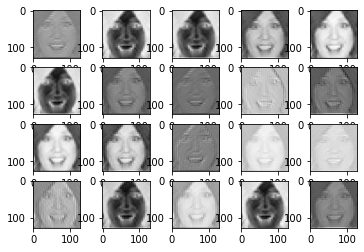

In [39]:
plt.figure()

for i in range(fmap0.squeeze().size(0))[:20]:
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap0.squeeze()[i].detach().numpy(), cmap = 'Greys')

In [34]:
## Visualize fmap - max_pool1
fmap1 = fmaps[1]
fmap1.squeeze().size(0)

50

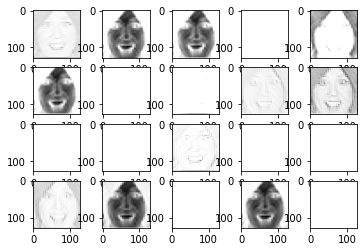

In [38]:
plt.figure()

for i in range(fmap1.squeeze().size(0))[:20]:
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap1.squeeze()[i].detach().numpy(), cmap = 'Greys')

In [36]:
## Visualize fmap - relu(conv2)
fmap2 = fmaps[2]
fmap2.squeeze().size(0)

50

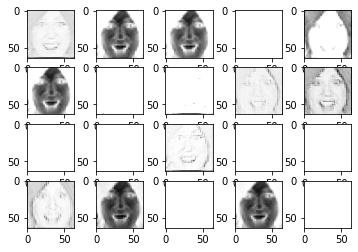

In [37]:
plt.figure()

for i in range(fmap2.squeeze().size(0))[:20]: # sample 20 from 50 chnnels
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap2.squeeze()[i].detach().numpy(), cmap = 'Greys')

fmap: 0
fmap: 1
fmap: 2
fmap: 3
fmap: 4
fmap: 5


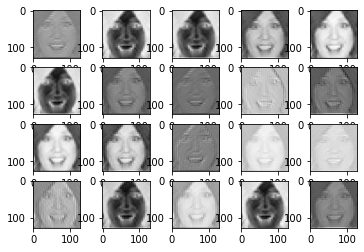

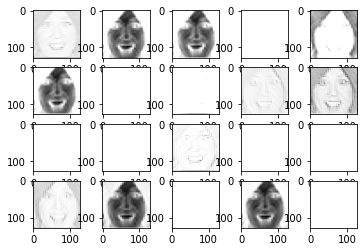

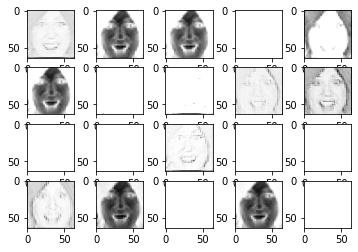

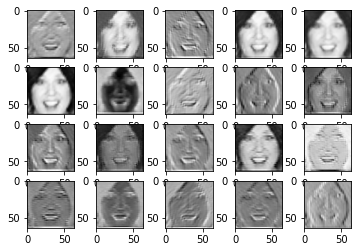

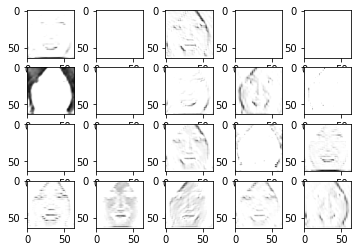

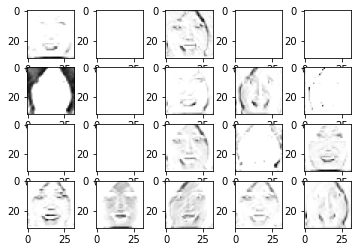

In [43]:
for j in range(len(fmaps))[:6]:
  ## Visualize fmap - max_pool2
  fmap = fmaps[j]
  fmap.squeeze().size(0)

  plt.figure()

  for i in range(fmap.squeeze().size(0))[:20]: # sample 20 from 50 chnnels
      plt.subplot(4, 5, i + 1)
      plt.imshow(fmap.squeeze()[i].detach().numpy(), cmap = 'Greys')